# Designing a simple calculator using Sequence to Sequence Networks

In this notebook we shall design a simple calculator using a sequence to sequence network. Now ofcourse this example is not supposed to be of any practical use, but the exact same network can be used to create a translator or a summarizer or any other sequence to sequence solution by just changing the input and output training sequences

### Creating the Dataset

First we import some of the basic libraries required to create the dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline



The challenge here is to design a calculator which can do the arithmetic operations of addition and subtraction (You can include other operations if you want) on two numbers. However we shall feed the entire input expression as a string and expect the output as a string too. The two numbers themselves can range from -9999 to 9999. The advantage of choosing this problem is that we can dynamically create as large a dataset as we want. Here we start off with dataset of 1 Million examples (Descrease this number of your training is going too slowly). 

In [2]:
allowed_ops=["+","-"]
min_input=-9999
max_input=9999
dataset_size=1000000

We define a function to generate the dataset. We take any two random integers between max_input and min_input and put a random arithmetic operator from the allowed operator list between them. We then evaluate the resulting expression to get our output. Finally we return both the input expression and the output as a tuple of strings

In [3]:
def generate_data(dataset_size):
    """Generates pairs of equations and solutions to them.
    
       Each equation has a form of two integers with an operator in between.
       Each solution is an integer with the result of the operation.
        dataset_size: an integer, number of equations to be generated.
        result: a list of tuples of strings (equation, solution).
    """
    sample=[]
    random.seed(42)
    for i in range(dataset_size):
        num1= random.randint(min_input, max_input)
        num2= random.randint(min_input, max_input)
        op= random.choice(allowed_ops)
        eqn= str(num1)+str(op)+str(num2)
        result= eval(eqn)
        sample.append((eqn, str(result)))
    return sample

We execute the function to get our dataset. We then do a standard train_test split (80-20).

In [4]:
data= generate_data(dataset_size)
train_data,test_data= train_test_split(data, test_size=0.2,random_state=42)

Let's have a look at some of the data we just generated 

In [5]:
print("First 3 training Samples",train_data[0:3])
print("Train_set_size=",len(train_data))
print("First 3 test Samples",test_data[0:3])
print("Test_set_size=",len(test_data))

First 3 training Samples [('439-6908', '-6469'), ('1145+-6208', '-5063'), ('-5787-6002', '-11789')]
Train_set_size= 800000
First 3 test Samples [('-7973--3050', '-4923'), ('-7352--1411', '-5941'), ('-3397+8826', '5429')]
Test_set_size= 200000


### Preparing the Data

We shall now define three additional special tokens to denote the start of the sequence (required for the decoder), the end of the sequence and a padding character which we shall use to bring our sequences to the same length while passing to the network

In [6]:
start_symbol="^"
end_symbol="$"
padding_symbol="#"

We append the end symbol at the end of our input and output data and the start symbol and the end of our output data. Note that we denote inputs as X and outputs as Y 

In [7]:
train_X=[i[0]+end_symbol for i in train_data]
train_Y=[start_symbol+i[1]+end_symbol for i in train_data]
test_X=[i[0]+end_symbol for i in test_data]
test_Y=[start_symbol+i[1]+end_symbol for i in test_data]

Let's have a look at the results

In [8]:
print("First 3 training Samples",train_X[0:3])
print("First 3 training output",train_Y[0:3])
print("First 3 test Samples",test_X[0:3])
print("First 3 test output",test_Y[0:3])


First 3 training Samples ['439-6908$', '1145+-6208$', '-5787-6002$']
First 3 training output ['^-6469$', '^-5063$', '^-11789$']
First 3 test Samples ['-7973--3050$', '-7352--1411$', '-3397+8826$']
First 3 test output ['^-4923$', '^-5941$', '^5429$']


The next step is tokenizing the data. Keras provides some handy tools for this purpose. We shall import the Tokenizer and pad_sequences modules

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


We now fit two different tokenizers for the X and Y sequences. Remember to only fit them on the training data. In this particular problem we shall be encoding characters and not words, so we set char_level=True. By default Keras filters out any punctuations and special characters. We don't want this so we set filters to None. 

Note- Although we dont encounter this in our problem, in general you will have some characters in our training set that are not present in the test set. In order to deal with this, the keras tokenizer provides the oov_token argument. All such unseen strings will be given the oov_token id if it is present. If you leave it as unspecified, all unseen words/ characters will be dropped. 

In [10]:
X_tokenizer= Tokenizer(filters=None, char_level=True)
X_tokenizer.fit_on_texts(train_X)
Y_tokenizer= Tokenizer(filters=None, char_level=True)
Y_tokenizer.fit_on_texts(train_Y)


We now create the tokenized versions of the input and output strings using the tokenizers. We also create a dictionary storing the mappings from character to id and vice versa. Note that we also add an token entry of 0 for the padding symbol. This is because the padding we shall do later by default pads the sequences with zeros

In [11]:
train_X_tokenized= X_tokenizer.texts_to_sequences(train_X)
train_Y_tokenized= Y_tokenizer.texts_to_sequences(train_Y)
test_X_tokenized= X_tokenizer.texts_to_sequences(test_X)
test_Y_tokenized= Y_tokenizer.texts_to_sequences(test_Y)
input_char2id={**X_tokenizer.word_index,**{padding_symbol:0}}
input_id2char={j:i for (i,j) in input_char2id.items()}
output_char2id={**Y_tokenizer.word_index,**{padding_symbol:0}}
output_id2char={j:i for (i,j) in output_char2id.items()}

We pad all our input and output sequences to the same length before we pass into the network. We define the maximum length of the input and output sequences and pad all sequences to this length. The pad_sequences functions allows us to pad/ truncate all sequences to a specified length. We also specify that we want the padding/truncating to be done after the end of the sentence 

In [12]:
input_max_len=13
output_max_len=7

In [13]:
train_X_padded=pad_sequences(train_X_tokenized,maxlen=input_max_len,padding="post",truncating="post",value=input_char2id[padding_symbol])
test_X_padded=pad_sequences(test_X_tokenized,maxlen=input_max_len,padding="post",truncating="post",value=input_char2id[padding_symbol])
train_Y_padded=pad_sequences(train_Y_tokenized,maxlen=output_max_len,padding="post",truncating="post",value=output_char2id[padding_symbol])
test_Y_padded=pad_sequences(test_Y_tokenized,maxlen=output_max_len,padding="post",truncating="post",value=output_char2id[padding_symbol])

### Results of Data Preparation

Lets have a look at the results of the data preparation we just did. First lets have a look at the input token to character mappings and the reverse.

In [14]:
print("Character to ID mapping for Input Sequences:",input_char2id)
print("ID to Character mapping for Input Sequences:",input_id2char)

Character to ID mapping for Input Sequences: {'-': 1, '$': 2, '5': 3, '1': 4, '7': 5, '4': 6, '9': 7, '2': 8, '6': 9, '8': 10, '3': 11, '0': 12, '+': 13, '#': 0}
ID to Character mapping for Input Sequences: {1: '-', 2: '$', 3: '5', 4: '1', 5: '7', 6: '4', 7: '9', 8: '2', 9: '6', 10: '8', 11: '3', 12: '0', 13: '+', 0: '#'}


The same for the output sequences

In [15]:
print("Character to ID mapping for Output Sequences:",output_char2id)
print("ID to Character mapping for Output Sequences:",output_id2char)

Character to ID mapping for Output Sequences: {'^': 1, '$': 2, '1': 3, '-': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '0': 13, '#': 0}
ID to Character mapping for Output Sequences: {1: '^', 2: '$', 3: '1', 4: '-', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '0', 0: '#'}


Before looking at the actual sequences themselves, we define a small utility function that maps a sequence of tokens to characters. We shall use it to check that everything is workinf correctly here. We shall also use it later while displaying outputs

In [16]:
def convert_to_chars(seq,id2char):
    return [id2char[i] for i in seq]
    

Now let's check if everything made sense for the training data.

In [17]:
id=0
print("Raw Input string:",train_X[id])
print("Tokenized Input:",train_X_tokenized[id])
print("Padded Input:",train_X_padded[id])
print("Tokenized Input converted back to characters:",convert_to_chars(train_X_padded[id],input_id2char))
print("Raw Output string:",train_Y[id])
print("Tokenized Output:",train_Y_tokenized[id])
print("Padded Output:",train_Y_padded[id])
print("Tokenized Output converted back to characters:",convert_to_chars(train_Y_padded[id],output_id2char))

Raw Input string: 439-6908$
Tokenized Input: [6, 11, 7, 1, 9, 7, 12, 10, 2]
Padded Input: [ 6 11  7  1  9  7 12 10  2  0  0  0  0]
Tokenized Input converted back to characters: ['4', '3', '9', '-', '6', '9', '0', '8', '$', '#', '#', '#', '#']
Raw Output string: ^-6469$
Tokenized Output: [1, 4, 9, 7, 9, 12, 2]
Padded Output: [ 1  4  9  7  9 12  2]
Tokenized Output converted back to characters: ['^', '-', '6', '4', '6', '9', '$']


Checking the Test data

In [18]:
id=0
print("Raw Input string:",test_X[id])
print("Tokenized Input:",test_X_tokenized[id])
print("Padded Input:",test_X_padded[id])
print("Tokenized Input converted back to characters:",convert_to_chars(test_X_padded[id],input_id2char))
print("Raw Output string:",test_Y[id])
print("Tokenized Output:",test_Y_tokenized[id])
print("Padded Output:",test_Y_padded[id])
print("Tokenized Output converted back to characters:",convert_to_chars(test_Y_padded[id],output_id2char))

Raw Input string: -7973--3050$
Tokenized Input: [1, 5, 7, 5, 11, 1, 1, 11, 12, 3, 12, 2]
Padded Input: [ 1  5  7  5 11  1  1 11 12  3 12  2  0]
Tokenized Input converted back to characters: ['-', '7', '9', '7', '3', '-', '-', '3', '0', '5', '0', '$', '#']
Raw Output string: ^-4923$
Tokenized Output: [1, 4, 7, 12, 5, 6, 2]
Padded Output: [ 1  4  7 12  5  6  2]
Tokenized Output converted back to characters: ['^', '-', '4', '9', '2', '3', '$']


### Definining Model Parameters

We define the size of the input and output vocabularies, the size of the input and output embedding vectors for the characters and the output size for the Encoder and decoder RNNs

In [19]:
input_vocab_size=len(input_char2id.keys())
input_embedding_size=20
output_vocab_size=len(output_char2id.keys())
output_embedding_size=20
hidden_size=512 ## Output size for RNNs

Importing the required modules for the Model

In [22]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

### The Encoder Model

The encoder model itself is very simple (Just 4 lines of code). It starts off with an Input layer. The Inputs are then fed through an Embedding layers. The embedded inputs then pass through a batch normalization layer. Batch Normalization normalizes the output between batches and helps with training stability. It is not really required for this problem but the idea was to be able to use this network for much more complicated problems. After Batch Normalization, we pass the inputs to a Bidirectional GRU. A bidirectional RNN is a combination of 2 RNNs , one which reads the forward sequence and other reads the reverse sequence. The outputs for the two RNN's are then averaged to get the final GRU output. This is the output we shall pass to the Decoder 

In [23]:

K.clear_session()
tf.reset_default_graph() ## These two commands clear any old graphs you might have in memory. Useful for retraining

#### Encoder Model ####
encoder_inputs = Input(shape=(input_max_len,), name='Encoder-Input')
x = Embedding(input_vocab_size,input_embedding_size, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)
out_gru= Bidirectional(GRU(hidden_size),merge_mode="ave")(x)


### The Decoder Model

The Decoder Model is very similar in nature too. Note that while training we shall be using teacher forcing, so we feed in the actual output sequences (token by token until the penultimate token) to the RNN. For each element of the output sequence that we feed in, we then require the Decoder to output the next element of the output sequence correctly. So we feed in these teacher forcing inputs via the input layer, which then pass through and embedding and a batch_normalization layer. We then feed  these sequences to the GRU decoder RNN. Note that to get all the outputs for an RNN intead of just the final output, we have to specify return_sequences=True in the GRU. We also feed the output of the encoder to the decoder RNN using the initial state parameter. The outputs of the RNN are then put through a single dense (fully connected) layer with output size= output vocabulary size with a softmax non-linearity. 

At the end of the day we are solving a multiclass classification problem for each character, so the output is a probability distribution for the output character at each stage.

In [24]:
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing
dec_emb = Embedding(output_vocab_size,output_embedding_size, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(hidden_size,return_sequences=True,name='Decoder-GRU')
decoder_gru_output= decoder_gru(dec_bn,initial_state=out_gru)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(output_vocab_size, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

### Combining the two into a Sequence to Sequence Model

The overall model is just a combination of the two. We simply define the input and output layers we are using to create the model

In [25]:
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Now we compile the model. As noted earlier, we are doing a multiclass classification, so the loss is categorical crossentropy. We use the sparse version to avoid going through the hassle of one hot encoding the targets.

In [26]:
seq2seq_Model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy')

Let's have a look at what we just created

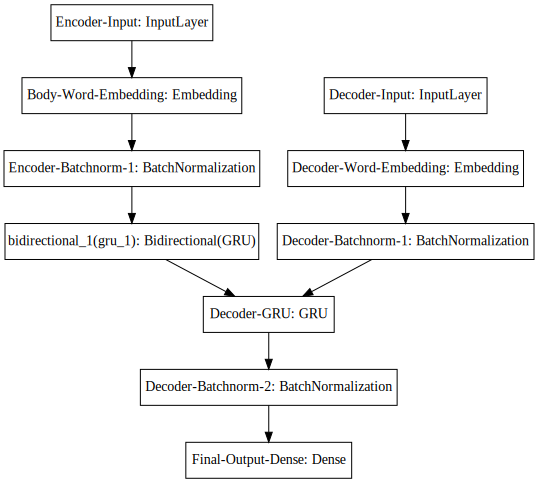

In [27]:
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(seq2seq_Model).create(prog='dot', format='svg')))


We can get a look at all the layers and their shapes and number of training parameters by using the summary function in keras. This function is incredibly useful in making sure all your layers are working the way they should.

In [28]:
seq2seq_Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      (None, 13)           0                                            
__________________________________________________________________________________________________
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Body-Word-Embedding (Embedding) (None, 13, 20)       280         Encoder-Input[0][0]              
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 20)     280         Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Ba

### Preparing the Inputs and Labels for the Network for Train and Test Data

We have one last step to go before we can start training. As I said earlier, in teacher forcing we feed in a particular token of the output sequence to the decoder and try to make it predict the next token in the sequence. In order for this to happen we define the decoder inputs as the 1st to N-1th tokens in the output sequence, while the decoder labels it tries to predict are the 2nd to the Nth element of the series. We create these arrays for both the train and test dataset. Note that no transformation needs to be made for the encoder data

In [29]:
train_dec_inp =train_Y_padded[:, :-1] # Training Decoder Input
train_dec_out = train_Y_padded[:, 1:]  # Training Decoder Labels
train_enc_inp=train_X_padded ## Training Encoder Input
test_dec_inp =test_Y_padded[:, :-1] # Testing Decoder Input
test_dec_out = test_Y_padded[:, 1:] # Testing Decoder Labels
test_enc_inp=test_X_padded # Testing Encoder Input

Lets have a look at the result of this

In [30]:
id=0
print("Encoder Input Sequence:",train_enc_inp[id])
print("Encoder Input converted back to characters",convert_to_chars(train_enc_inp[id],input_id2char))
print("Decoder Input Sequence",train_dec_inp[id])
print("Decoder Input converted back to characters",convert_to_chars(train_dec_inp[id],output_id2char))
print("Decoder Output Sequence",train_dec_out[id])
print("Decoder Output converted back to characters",convert_to_chars(train_dec_out[id],output_id2char))


Encoder Input Sequence: [ 6 11  7  1  9  7 12 10  2  0  0  0  0]
Encoder Input converted back to characters ['4', '3', '9', '-', '6', '9', '0', '8', '$', '#', '#', '#', '#']
Decoder Input Sequence [ 1  4  9  7  9 12]
Decoder Input converted back to characters ['^', '-', '6', '4', '6', '9']
Decoder Output Sequence [ 4  9  7  9 12  2]
Decoder Output converted back to characters ['-', '6', '4', '6', '9', '$']


### Training the Model

We now start training the model. The Model.fit() command does the training. We have to pass the model the training and testing (validation) data. We also specify the number of epochs and the batch size. Finally we use the Keras ModelChekpoint callback to save the best weights during our training. The best model is decided on the basis of the validation loss.

Note-  The BatchNormalization Layer behaves slightly differently between training and testing. So we set the Keras Learning Phase to 1 to show that right now we are in training. 0 would indicate testing/ Inference. Note that that while outputting validation losses, Keras automatically takes care of setting the learning phase. We set it here mainly because we will be resetting it during inference.

In [116]:
from keras.callbacks import CSVLogger, ModelCheckpoint
K.set_learning_phase(1)
model_checkpoint = ModelCheckpoint('best_weights.hdf5',
                                   save_best_only=True)
batch_size = 5120
epochs = 20
history = seq2seq_Model.fit(x=[train_enc_inp, train_dec_inp],y=np.expand_dims(train_dec_out,-1),epochs=epochs,
                            validation_data=[[test_enc_inp,test_dec_inp],np.expand_dims(test_dec_out,-1)],batch_size=batch_size,
                            callbacks=[model_checkpoint])

Train on 800000 samples, validate on 200000 samples
Epoch 1/20
800000/800000 [==============================] - 49s 61us/step - loss: 1.9769 - val_loss: 1.4077
Epoch 2/20
800000/800000 [==============================] - 48s 60us/step - loss: 1.3005 - val_loss: 1.2218
Epoch 3/20
800000/800000 [==============================] - 48s 60us/step - loss: 1.1751 - val_loss: 1.2605
Epoch 4/20
800000/800000 [==============================] - 48s 60us/step - loss: 1.1162 - val_loss: 1.0575
Epoch 5/20
800000/800000 [==============================] - 48s 60us/step - loss: 1.0576 - val_loss: 0.9659
Epoch 6/20
800000/800000 [==============================] - 48s 60us/step - loss: 0.8285 - val_loss: 0.7413
Epoch 7/20
800000/800000 [==============================] - 48s 60us/step - loss: 0.7229 - val_loss: 0.6814
Epoch 8/20
800000/800000 [==============================] - 48s 60us/step - loss: 0.6439 - val_loss: 0.6795
Epoch 9/20
800000/800000 [==============================] - 48s 60us/step - loss: 0.

### Inference Using the trained Model

First we load in the best weights during our training and set the learning phase to 0 for inference.

In [31]:
#seq2seq_Model.load_weights("best_weights.hdf5")
seq2seq_Model.load_weights("saved_awesome_weights.hdf5")
K.set_learning_phase(0)


#### Encoder for Inference

Getting the encoder back from the trained model is simple. We just define a new model using the first and last layer of our encoder Model

In [32]:
def extract_encoder(model):
    return Model(model.get_layer("Encoder-Input").input,model.get_layer("bidirectional_1").output)

#### Decoder for Inference

Recoonstructing the decoder for Inference involves recalling the layers one by one (There is a nicer way to do this by encapsulating the models earlier but this works for now). However we add an extra input layer where we take in the output of the encoder model and pass it as the initial state of the Decoder RNN. We also get not only the output of the Dense projection layer but also the RNN output state as our outputs

In [33]:
def extract_decoder(model):
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)
    gru_inference_state_input = Input(shape=(hidden_size,), name='hidden_state_input')
    gru_out = model.get_layer('Decoder-GRU')(dec_bn, initial_state=gru_inference_state_input)
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input],
                          [dense_out, gru_out])
    return decoder_model

#### Inference Loop

To actually run inference, we create the function below. The function first extracts the encoder and decoder from the seq2seq model. Then we pass the input string to the encoder and get the encoded output. We then feed this encoder output as the initial state input for the decoder model. For the sequence input character, we seed the sequence with the start character. We then run the decoder one step to get the first predicted output character and the output state of the RNN.  We then take the output character as our new input character and the RNN state as our new RNN state and run the decoder in a loop till we either get the Eend symbol as our output or we hit a maximum length.

In [34]:
def infer_on_sample(input_array,model=seq2seq_Model):
    encoder_model=extract_encoder(model)
    decoder_model=extract_decoder(model)
    body_encoding = encoder_model.predict(input_array)
    state_value = np.array(output_char2id[start_symbol]).reshape(1, 1)
    decoded_seq = []
    while True:
        preds, st = decoder_model.predict([state_value, body_encoding])
        sampled_token_index = np.argmax(preds)
        sampled_char = output_id2char[sampled_token_index]
        if sampled_char ==end_symbol or len(decoded_seq) >output_max_len:
                break
        decoded_seq.append(sampled_char)
        body_encoding = st[0]
        state_value = np.array(sampled_token_index).reshape(1, 1)

    return ''.join(decoded_seq)

The cell below contains a couple of functions to calculate and pretty print the inference results on some elements of the test set.

In [37]:
def infer_on_array(inp_array,actual_outputs):
    for i,j in enumerate(inp_array):
        print(f"========= Example {i} ============")
        inp_string="".join(convert_to_chars(j,input_id2char))
        label_string="".join(convert_to_chars(actual_outputs[i],output_id2char))
        print(f"Input Expression --> {inp_string.split(end_symbol)[0]}")
        print(f"Actual Output Expression --> {label_string.lstrip(start_symbol).split(end_symbol)[0]}")
        pred= infer_on_sample(np.expand_dims(j,0))
        print(f"Predicted Output --> {pred}")
        print("====================================")
    return

def gen_random_inferences(n=20):
    sz=test_X_padded.shape[0]
    random_indices=np.random.randint(0,sz,size=n)
    return infer_on_array(test_X_padded[random_indices],test_Y_padded[random_indices])

Lets see how we did. If your training went well, you should see an almost perfect calculator

In [38]:
gen_random_inferences()

========= Example 0 ============
Input Expression --> -1023+-6098
Actual Output Expression --> -7121
Predicted Output --> -7121
========= Example 1 ============
Input Expression --> 4942--7686
Actual Output Expression --> 12628
Predicted Output --> 12628
========= Example 2 ============
Input Expression --> 3303+-9481
Actual Output Expression --> -6178
Predicted Output --> -6178
========= Example 3 ============
Input Expression --> -5353--5996
Actual Output Expression --> 643
Predicted Output --> 643
========= Example 4 ============
Input Expression --> -6958--4340
Actual Output Expression --> -2618
Predicted Output --> -2618
========= Example 5 ============
Input Expression --> 1892--5676
Actual Output Expression --> 7568
Predicted Output --> 7568
========= Example 6 ============
Input Expression --> 9549+8526
Actual Output Expression --> 18075
Predicted Output --> 18075
========= Example 7 ============
Input Expression --> 1668+7104
Actual Output Expression --> 8772
Predicted Output 

# That's all folks...